In [1]:
import os
import time
import math
import random
import pickle
import shutil
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from drift_detectors import *
from forecasters import *
from autoencoder import *
from utils import *
from data import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
# Set a global seed for reproducibility
seed = 42

# Seed Python, NumPy, and PyTorch RNGs
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create and seed a PyTorch Generator (for Dataloaders)
g= torch.Generator()
g.manual_seed(seed)

# Seed CUDA (if available)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior in cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Directory paths for saving and loading components
AE_DIR = "trained_autoencoders"
FORECASTERS_DIR= "trained_forecasters"
RESULTS_DIR = "results"

# Size of the autoencoder bottleneck
latent_dim = 2

# Dataset configurations: (Name, Class, Sequence Length, Window Size)
ts_configs = [
    ("Sudden", Sudden, None, 10),
    ("Gradual", Gradual, None, 10),
]

# Flags to toggle use of autoencoder embeddings
autoencoder_embedding_flags = [False, True]

# Distance metrics to evaluate
metrics_list = ["dtw", "euclidean", "cosine", "manhattan"]

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



Training AE on Sudden (window_size=10)
  Epoch 1/30 — loss: 0.574753
  Epoch 2/30 — loss: 0.271616
  Epoch 3/30 — loss: 0.212320
  Epoch 4/30 — loss: 0.185262
  Epoch 5/30 — loss: 0.164091
  Epoch 6/30 — loss: 0.156946
  Epoch 7/30 — loss: 0.140132
  Epoch 8/30 — loss: 0.132005
  Epoch 9/30 — loss: 0.121326
  Epoch 10/30 — loss: 0.114960
  Epoch 11/30 — loss: 0.111557
  Epoch 12/30 — loss: 0.103569
  Epoch 13/30 — loss: 0.103588
  Epoch 14/30 — loss: 0.099164
  Epoch 15/30 — loss: 0.092631
  Epoch 16/30 — loss: 0.093263
  Epoch 17/30 — loss: 0.090138
  Epoch 18/30 — loss: 0.088938
  Epoch 19/30 — loss: 0.082105
  Epoch 20/30 — loss: 0.083977
  Epoch 21/30 — loss: 0.081950
  Epoch 22/30 — loss: 0.080923
  Epoch 23/30 — loss: 0.080155
  Epoch 24/30 — loss: 0.076836
  Epoch 25/30 — loss: 0.076347
  Epoch 26/30 — loss: 0.073591
  Epoch 27/30 — loss: 0.070701
  Epoch 28/30 — loss: 0.069818
  Epoch 29/30 — loss: 0.069399
  Epoch 30/30 — loss: 0.067835
Saved AE: trained_autoencoders\ae_Sudde

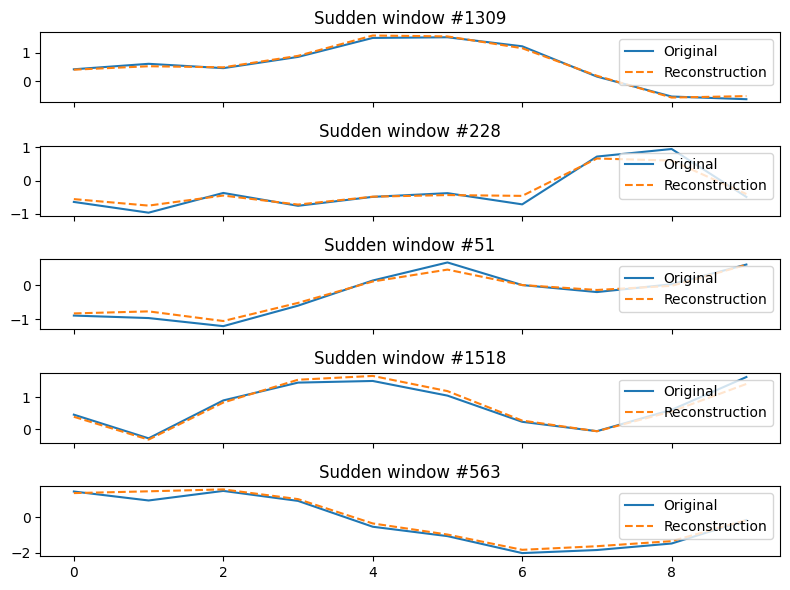


Training AE on Gradual (window_size=10)
  Epoch 1/30 — loss: 0.538666
  Epoch 2/30 — loss: 0.233888
  Epoch 3/30 — loss: 0.185620
  Epoch 4/30 — loss: 0.162625
  Epoch 5/30 — loss: 0.147122
  Epoch 6/30 — loss: 0.132851
  Epoch 7/30 — loss: 0.126747
  Epoch 8/30 — loss: 0.121643
  Epoch 9/30 — loss: 0.113677
  Epoch 10/30 — loss: 0.108387
  Epoch 11/30 — loss: 0.104639
  Epoch 12/30 — loss: 0.099450
  Epoch 13/30 — loss: 0.096878
  Epoch 14/30 — loss: 0.091250
  Epoch 15/30 — loss: 0.092871
  Epoch 16/30 — loss: 0.089804
  Epoch 17/30 — loss: 0.090868
  Epoch 18/30 — loss: 0.087063
  Epoch 19/30 — loss: 0.082739
  Epoch 20/30 — loss: 0.081958
  Epoch 21/30 — loss: 0.081345
  Epoch 22/30 — loss: 0.080113
  Epoch 23/30 — loss: 0.079795
  Epoch 24/30 — loss: 0.080183
  Epoch 25/30 — loss: 0.075201
  Epoch 26/30 — loss: 0.073457
  Epoch 27/30 — loss: 0.075201
  Epoch 28/30 — loss: 0.074311
  Epoch 29/30 — loss: 0.077181
  Epoch 30/30 — loss: 0.074531
Saved AE: trained_autoencoders\ae_Grad

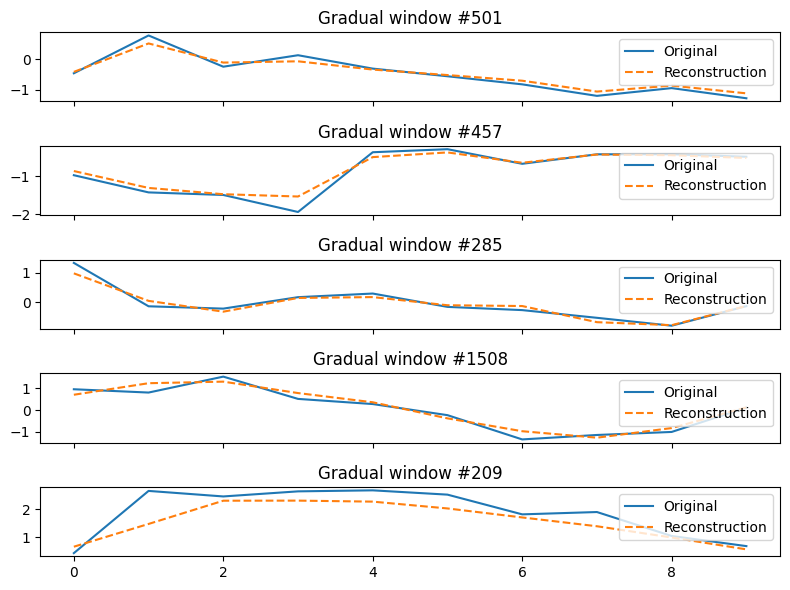

In [4]:
# Autoencoder Training Settings
epochs    = 30
lr        = 1e-3
dropout_p = 0.3

# Ensure a clean autoencoders/ directory
if os.path.exists(AE_DIR):
    shutil.rmtree(AE_DIR)
os.makedirs(AE_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=128, 
        shuffle=True, 
        generator= g
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_val)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [5]:
# Ensure a clean forecasters/ directory
if os.path.exists(FORECASTERS_DIR):
    shutil.rmtree(FORECASTERS_DIR)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(random_state=seed),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(random_state=seed),
    "DT": DecisionTreeForecaster(random_state=seed),
    "MLP1": MLPForecaster(hidden_layer_sizes=(64,), random_state=seed),
    "MLP2": MLPForecaster(hidden_layer_sizes=(64, 32), random_state=seed),
    "MLP3": MLPForecaster(hidden_layer_sizes=(128, 64, 32), random_state=seed),
    "LSTM1": LSTMForecaster(),
    "LSTM2": LSTMForecaster(num_layers=2),
    "LSTM3": LSTMForecaster(num_layers=3),
    "BiLSTM1": BiLSTMForecaster(),
    "BiLSTM2": BiLSTMForecaster(num_layers=2),
    "BiLSTM3": BiLSTMForecaster(num_layers=3),
    "CNNLSTM1": CNNLSTMForecaster(),
    "CNNLSTM2": CNNLSTMForecaster(lstm_num_layers=2),
    "CNNLSTM3": CNNLSTMForecaster(lstm_num_layers=3),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train, generator=g)

        # save the entire model object as a .pkl
        save_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE")


→ Dataset: Sudden (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP1… DONE
    → Training MLP2… DONE
    → Training MLP3… DONE
    → Training LSTM1… 1/30 0.81179 | 15/30 0.37335 | 30/30 0.37047 | DONE
    → Training LSTM2… 1/30 0.81855 | 15/30 0.37631 | 30/30 0.37394 | DONE
    → Training LSTM3… 1/30 0.87690 | 15/30 0.38108 | 30/30 0.37446 | DONE
    → Training BiLSTM1… 1/30 0.83946 | 15/30 0.37085 | 30/30 0.36979 | DONE
    → Training BiLSTM2… 1/30 0.69170 | 15/30 0.37127 | 30/30 0.37130 | DONE
    → Training BiLSTM3… 1/30 0.73170 | 15/30 0.37438 | 30/30 0.37350 | DONE
    → Training CNNLSTM1… 1/30 0.67545 | 15/30 0.38029 | 30/30 0.38572 | DONE
    → Training CNNLSTM2… 1/30 0.74604 | 15/30 0.39006 | 30/30 0.38117 | DONE
    → Training CNNLSTM3… 1/30 0.81422 | 15/30 0.38837 | 30/30 

In [6]:
os.makedirs(AE_DIR, exist_ok=True)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

loaded = {}
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {AE_DIR}{os.sep}")
    
    # Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP1",
        "MLP2",
        "MLP3",
        "LSTM1",
        "LSTM2",
        "LSTM3",
        "BiLSTM1",
        "BiLSTM2",
        "BiLSTM3",
        "CNNLSTM1",
        "CNNLSTM2",
        "CNNLSTM3",
    ]:
        pkl_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
    print(f"     Forecasters loaded from {FORECASTERS_DIR}{os.sep}")
    
    # Store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Sudden (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for Gradual (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\


In [7]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")


=== Validation RoC for Sudden (window_size=10) ===
RoC sizes
  ARIMA               303 entries
  ExpSmoothing        302 entries
  LinearRegression     24 entries
  RandomForest         56 entries
  SVR                  29 entries
  GradientBoosting    118 entries
  DT                  193 entries
  MLP1                102 entries
  MLP2                165 entries
  MLP3                 98 entries
  LSTM1                40 entries
  LSTM2                56 entries
  LSTM3                28 entries
  BiLSTM1              21 entries
  BiLSTM2              21 entries
  BiLSTM3              16 entries
  CNNLSTM1             24 entries
  CNNLSTM2             90 entries
  CNNLSTM3             54 entries

=== Validation RoC for Gradual (window_size=10) ===
RoC sizes
  ARIMA               302 entries
  ExpSmoothing        310 entries
  LinearRegression     24 entries
  RandomForest         58 entries
  SVR                  28 entries
  GradientBoosting    115 entries
  DT                  194

Bottleneck size: 2

=== Compute K-means centers for Sudden (window_size=10) ===


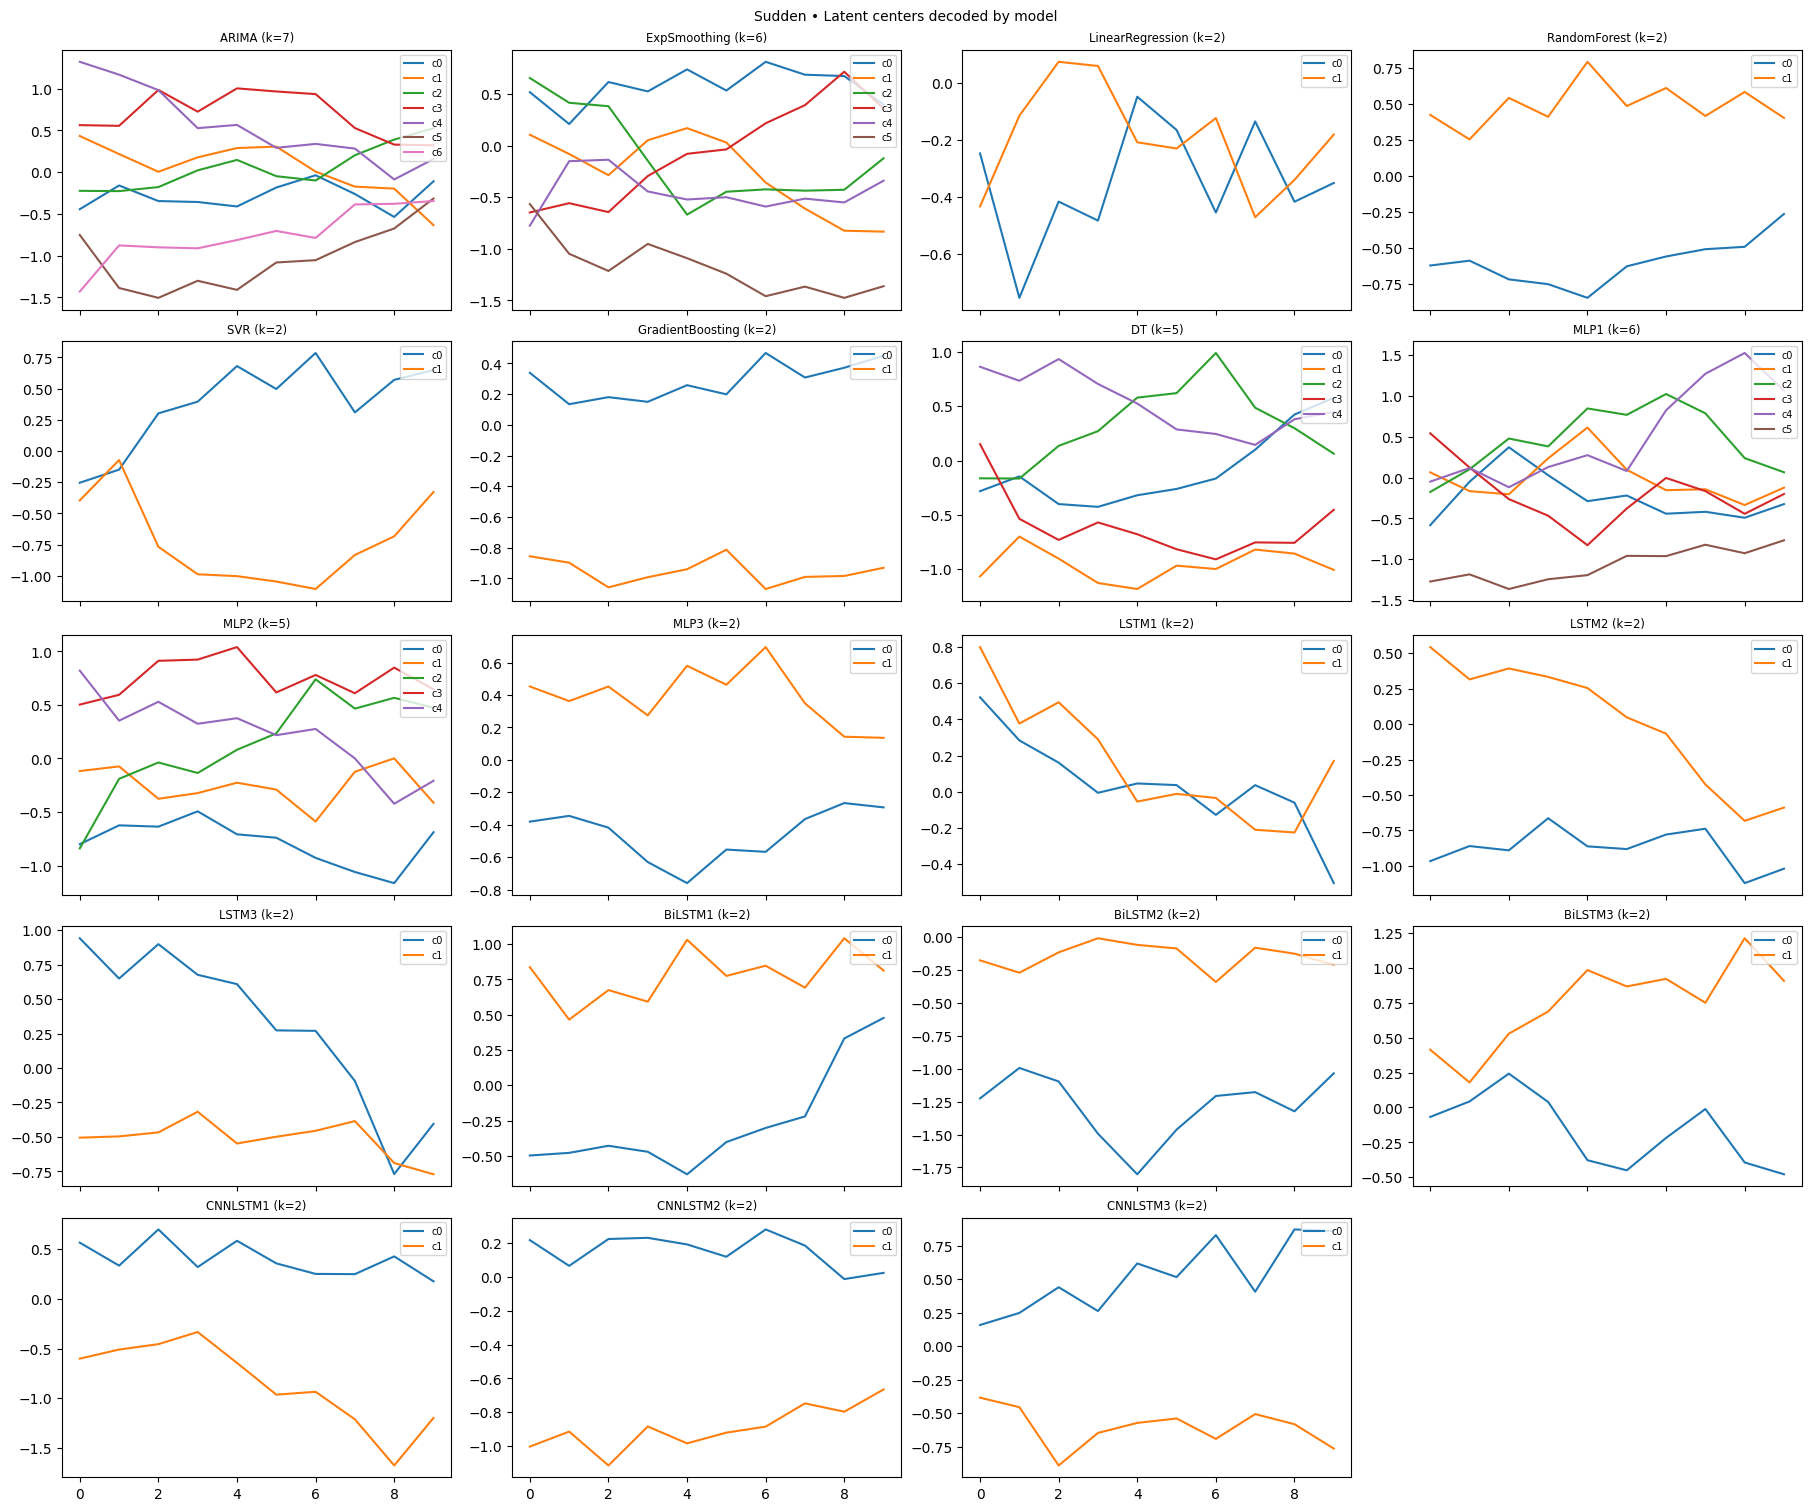


=== Compute K-means centers for Gradual (window_size=10) ===


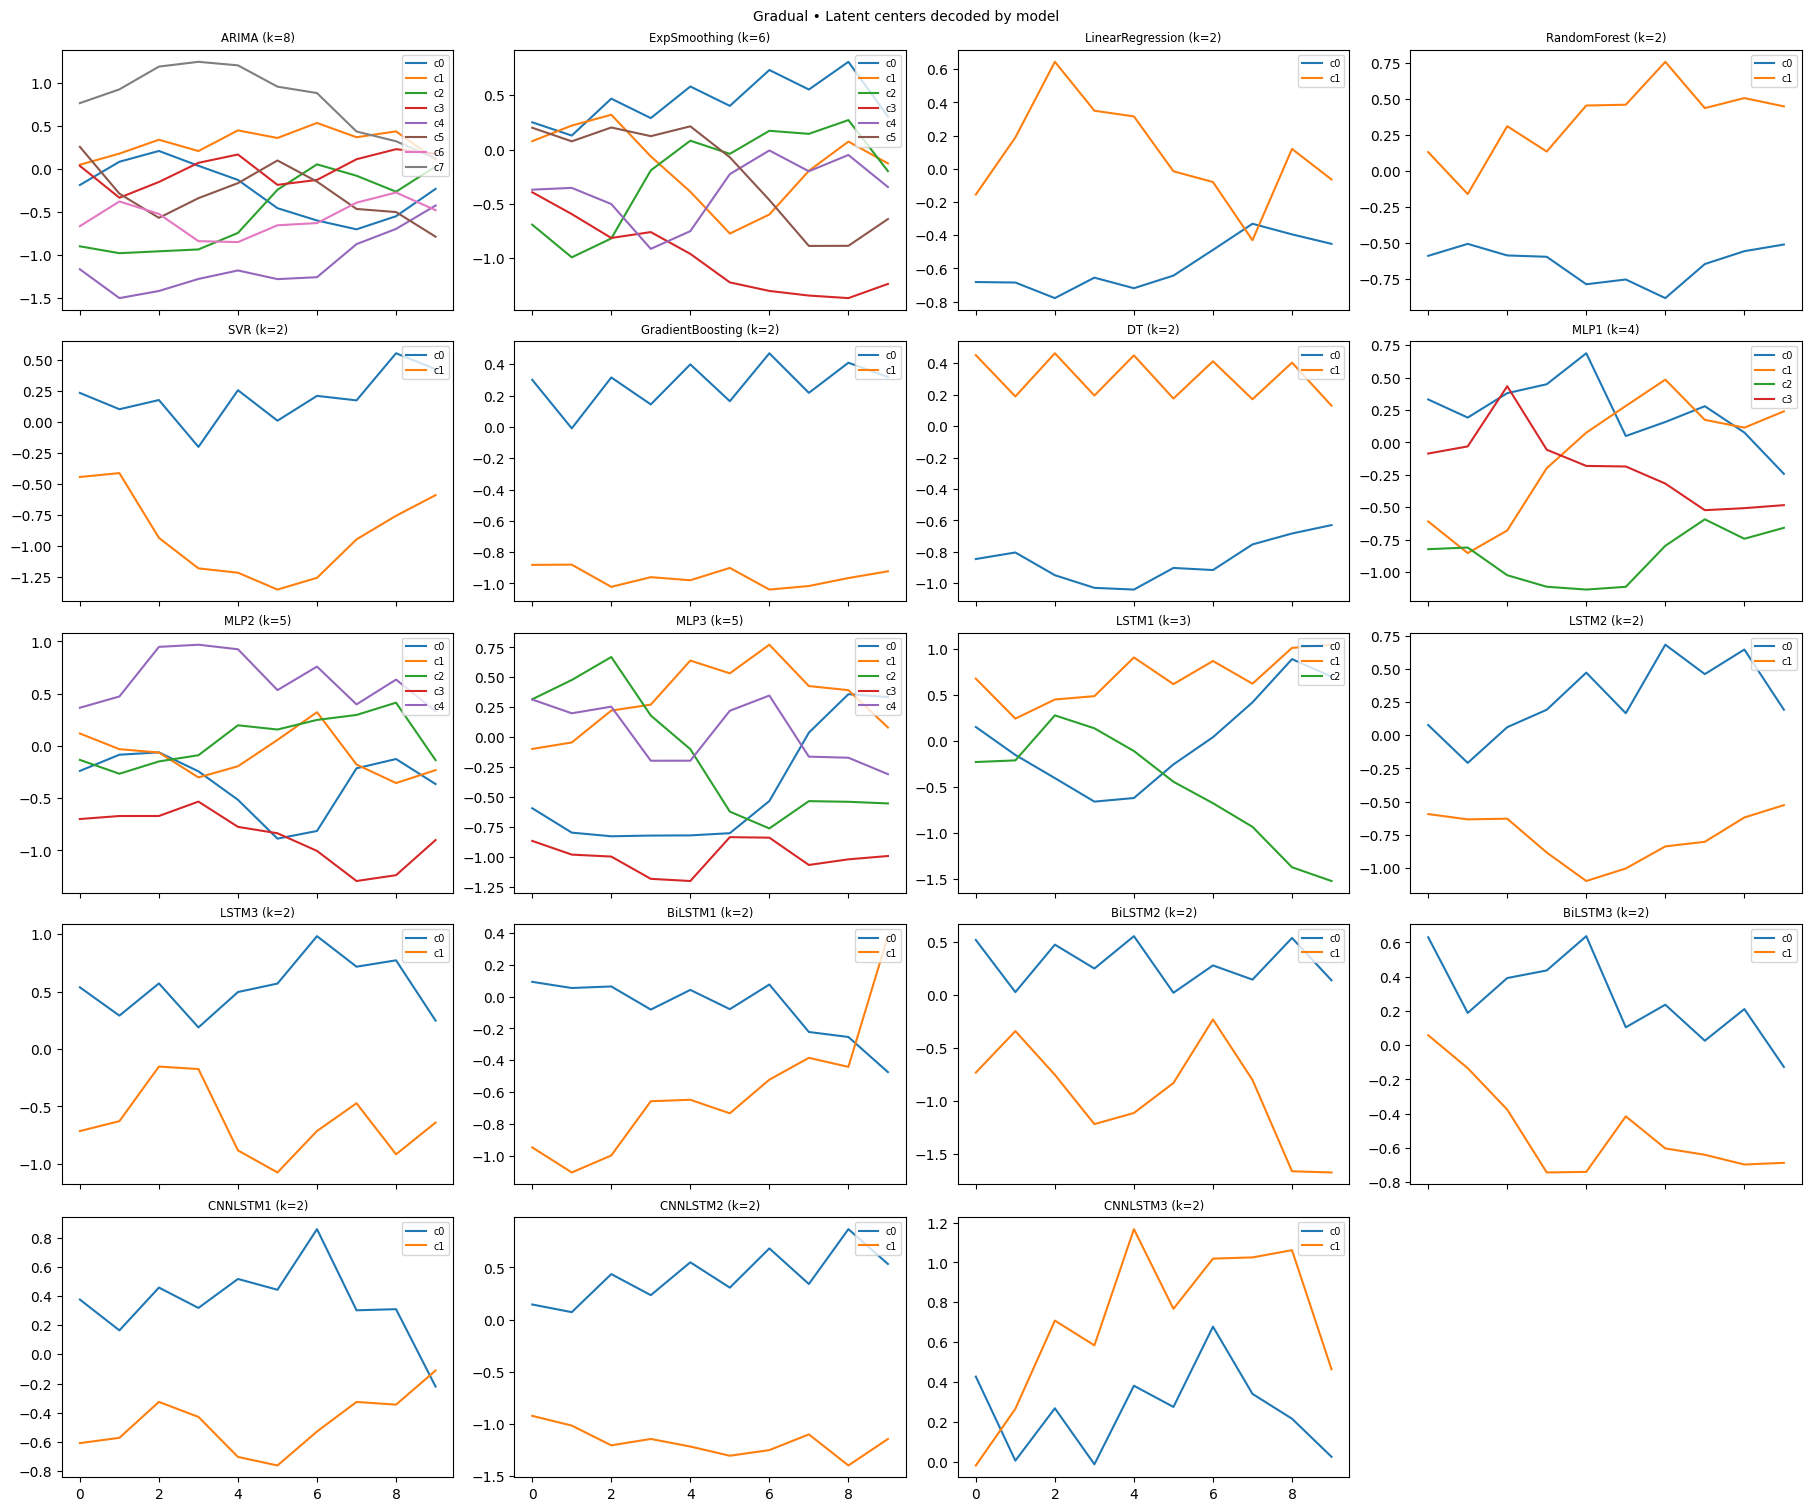

In [8]:
n_cols = 4
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Compute K-means centers for {ds_name} (window_size={window_size}) ===")

    # Load models
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear previous centers
    for model in forecasters.values():
        model.centers = {"raw": [], "latent": []}

    # Determine device for decoding latent centers
    decoder_device = next(ae.decoder.parameters()).device

    for name, model in forecasters.items():
        # Cluster latent RoCs
        N_latent = len(model.rocs["latent"])
        if N_latent > 0:
            k_max_latent = np.sqrt(N_latent / 2)
            model.compute_kmeans_centers(mode="latent", k_max=k_max_latent, random_state=seed)

        # Cluster raw RoCs
        N_raw = len(model.rocs["raw"])
        if N_raw > 0:
            k_max_raw = np.sqrt(N_raw / 2)
            model.compute_kmeans_centers(mode="raw", k_max=k_max_raw, random_state=seed)

    # Plot all latent cluster centers (decoded)
    names = [n for n in forecasters if len(forecasters[n].centers["latent"]) > 0]
    n_models = len(names)
    if n_models == 0:
        print(" No models have centers to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, name in zip(axes, names):
        model = forecasters[name]
        for idx, c in enumerate(model.centers["latent"]):
            # ensure tensor on correct device
            c_tensor = c if isinstance(c, torch.Tensor) else torch.tensor(
                c, dtype=torch.float32
            )
            c_batch = c_tensor.unsqueeze(0).to(decoder_device)  # shape (1, C, L)
            decoded = ae.decoder(c_batch)                       # -> (1, 1, window_size)
            ts_data = decoded.detach().cpu().numpy().flatten()
            ax.plot(ts_data, label=f"c{idx}")
        ax.set_title(f"{name} (k={len(model.centers['latent'])})", fontsize="small")
        ax.legend(loc="upper right", fontsize="x-small")

    # turn off any unused subplots
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent centers decoded by model", fontsize="medium")
    plt.show()


=== Plot latent cluster samples for Sudden (compact grid) ===


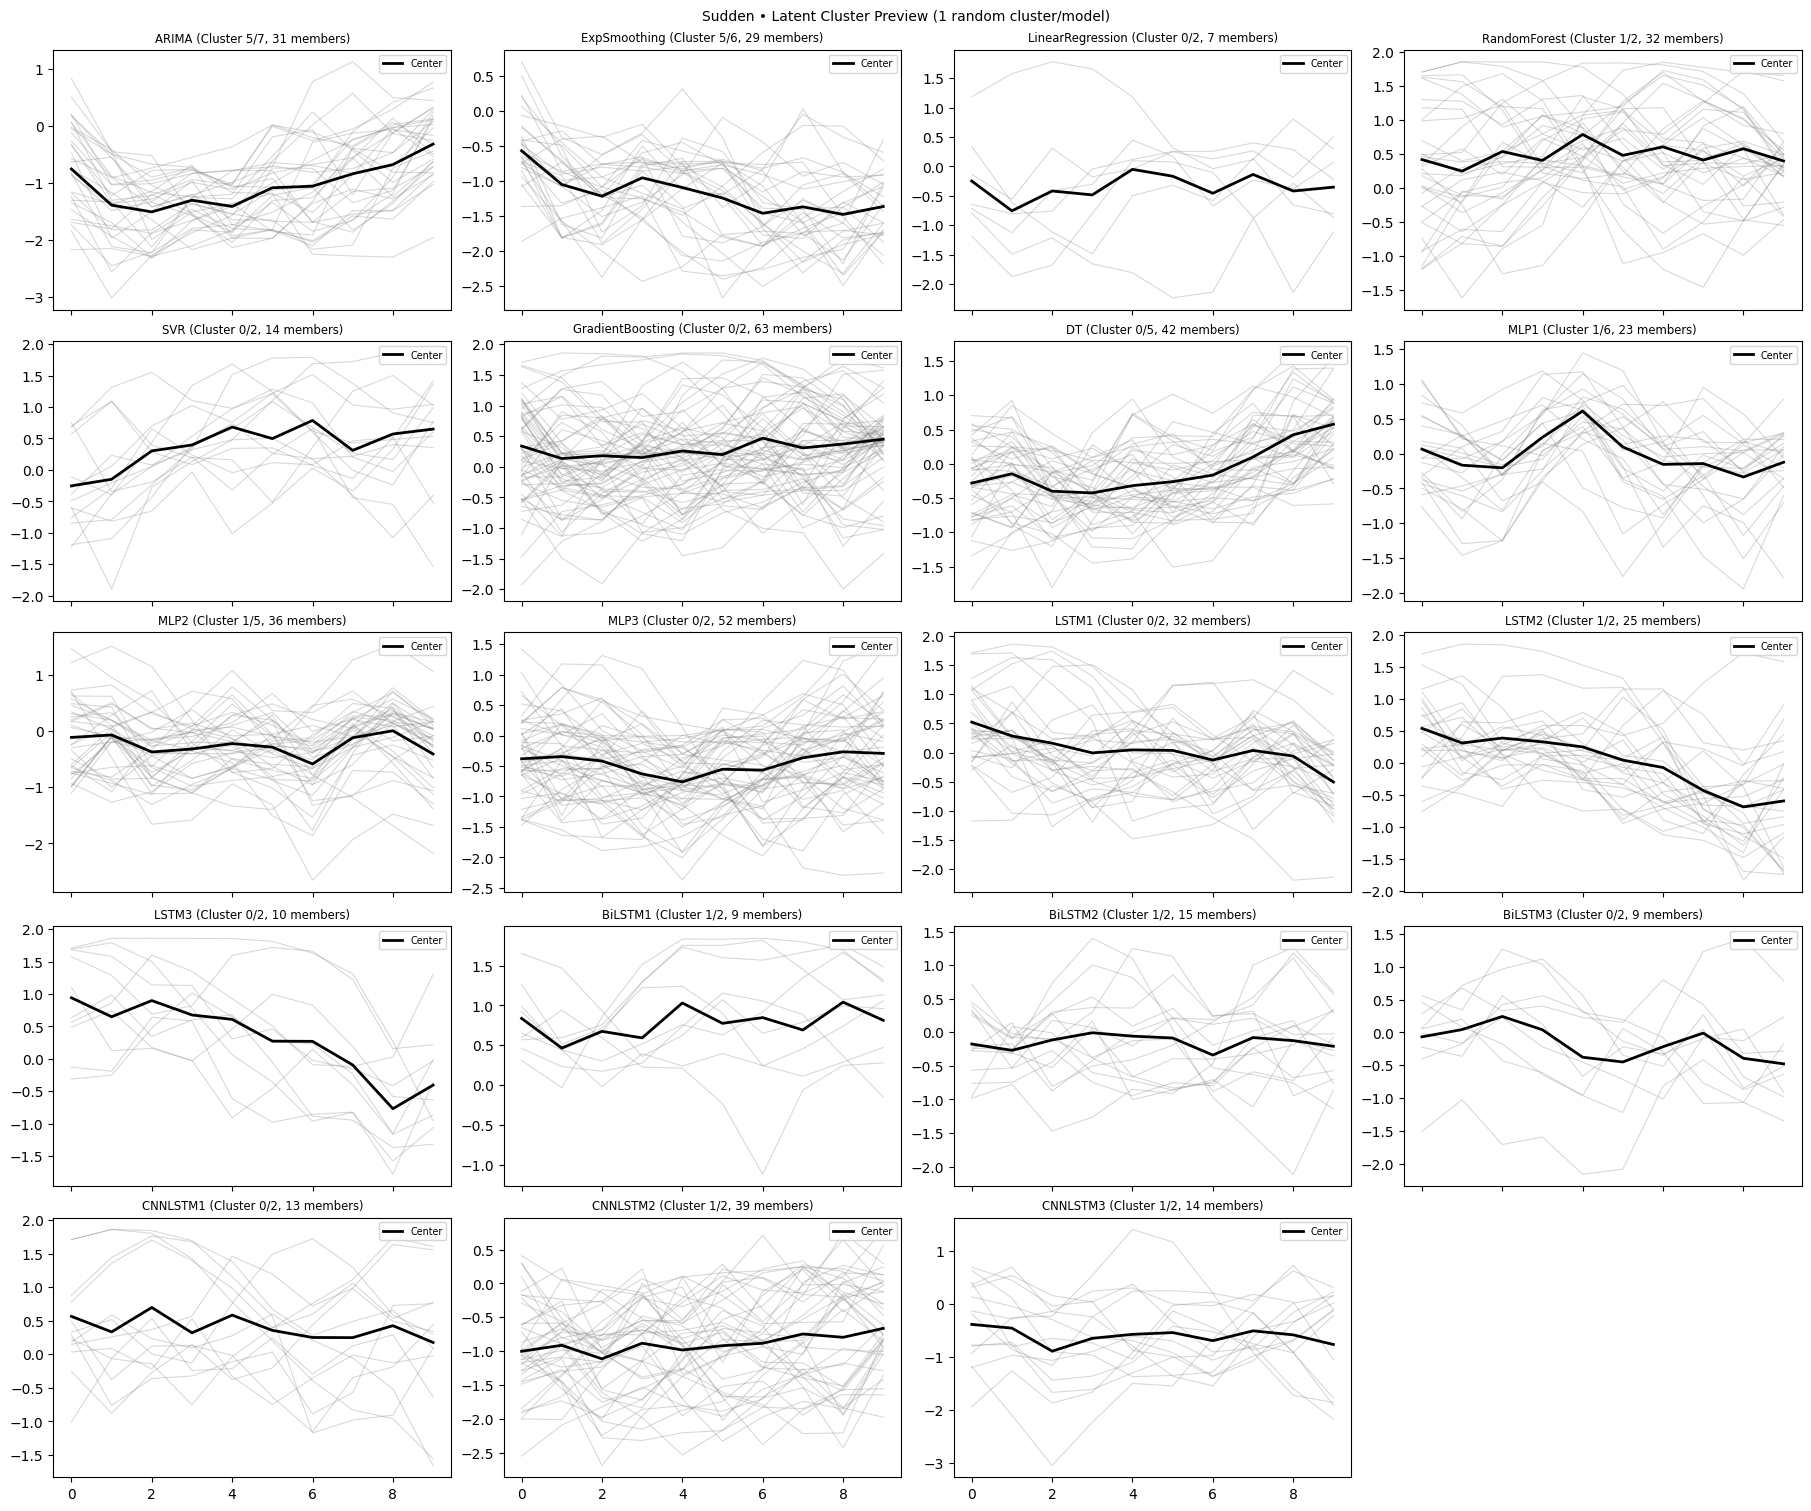


=== Plot latent cluster samples for Gradual (compact grid) ===


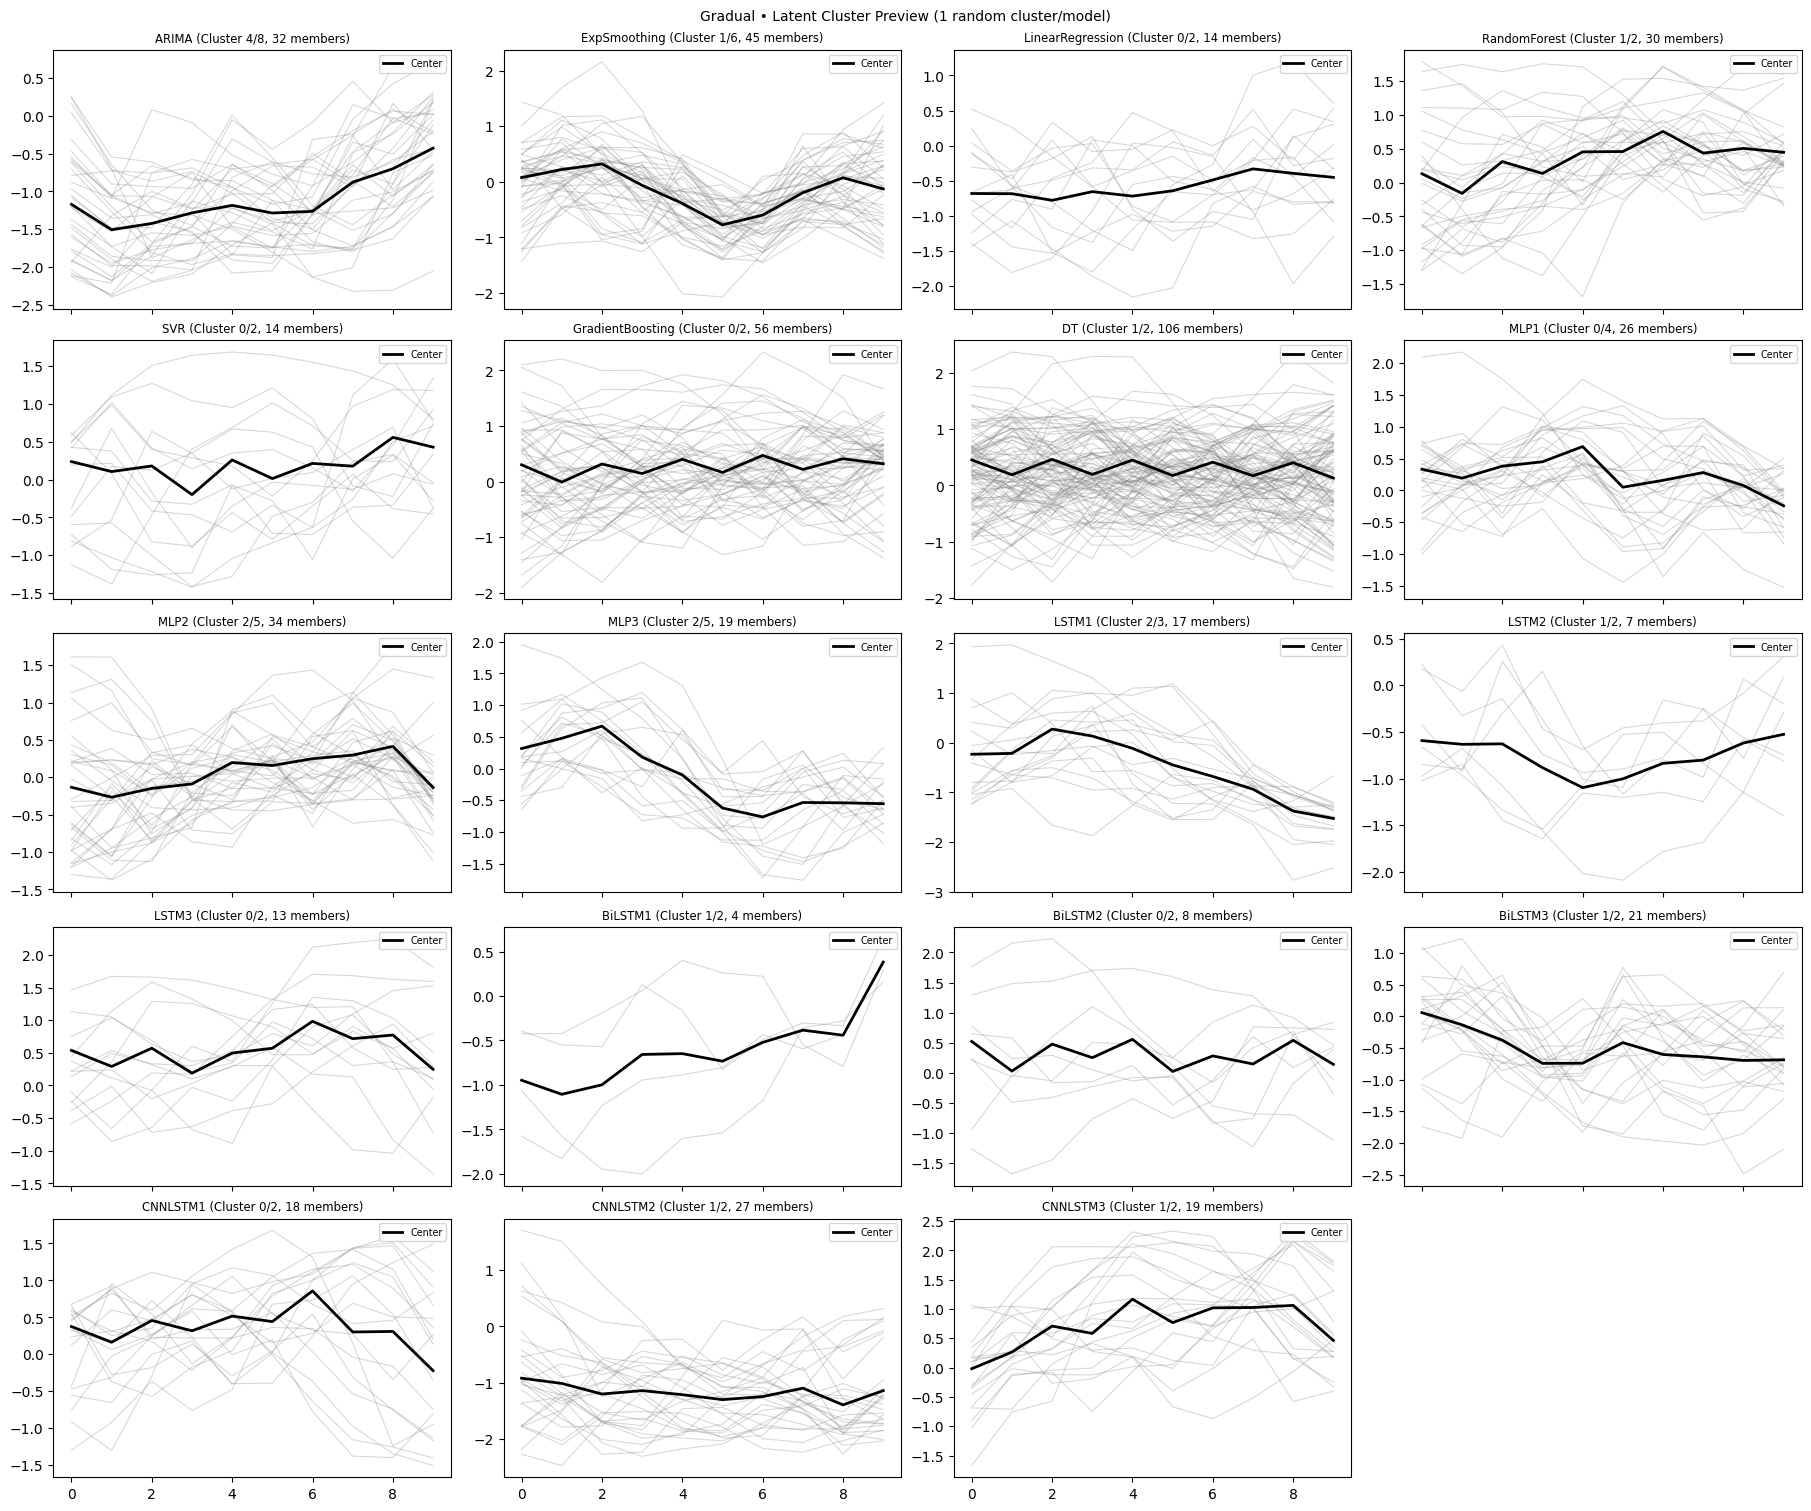

In [9]:
n_cols = 4
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Plot latent cluster samples for {ds_name} (compact grid) ===")

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    decoder_device = next(ae.decoder.parameters()).device

    valid_models = []
    for name, model in forecasters.items():
        centers = model.centers["latent"]
        windows = model.rocs["latent"]

        if len(centers) == 0 or len(windows) == 0:
            continue

        # Flatten latent windows
        X = np.vstack([
            (w.detach().cpu().numpy() if isinstance(w, torch.Tensor) else np.array(w)).flatten()
            for w in windows
        ])

        # Flatten latent centers
        C = np.vstack([
            (c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else np.array(c)).flatten()
            for c in centers
        ])

        # Use KMeans.predict with existing centers
        km = KMeans(n_clusters=len(C), init=C, n_init=1, max_iter=1, random_state=seed)
        labels = km.fit_predict(X)

        # Group windows by cluster
        cluster_to_indices = {i: [] for i in range(len(C))}
        for idx, label in enumerate(labels):
            cluster_to_indices[label].append(idx)

        valid_models.append((name, model, centers, cluster_to_indices, windows))

    n_models = len(valid_models)
    if n_models == 0:
        print(" No valid models to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, (name, model, centers, cluster_to_indices, windows) in zip(axes, valid_models):
        non_empty_clusters = [i for i, idxs in cluster_to_indices.items() if len(idxs) > 0]
        if not non_empty_clusters:
            ax.set_title(f"{name} (no populated clusters)", fontsize="small")
            ax.axis("off")
            continue

        chosen_c = random.choice(non_empty_clusters)
        member_indices = cluster_to_indices[chosen_c]

        for i in member_indices:
            w_tensor = windows[i].unsqueeze(0).to(decoder_device)
            decoded = ae.decoder(w_tensor).detach().cpu().numpy().flatten()
            ax.plot(decoded, alpha=0.3, linewidth=0.8, color='gray')

        c_tensor = centers[chosen_c].unsqueeze(0).to(decoder_device)
        decoded_center = ae.decoder(c_tensor).detach().cpu().numpy().flatten()
        ax.plot(decoded_center, color='black', linewidth=2, label="Center")

        ax.set_title(
            f"{name} (Cluster {chosen_c}/{len(centers)}, {len(member_indices)} members)",
            fontsize="small"
        )
        ax.legend(loc="upper right", fontsize="x-small")

    # Turn off unused axes
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent Cluster Preview (1 random cluster/model)",
                 fontsize="medium")
    plt.show()

Bottleneck size: 2

=== Dataset: Sudden ===
  > Metric: euclidean
    -> MSE: 4.5640


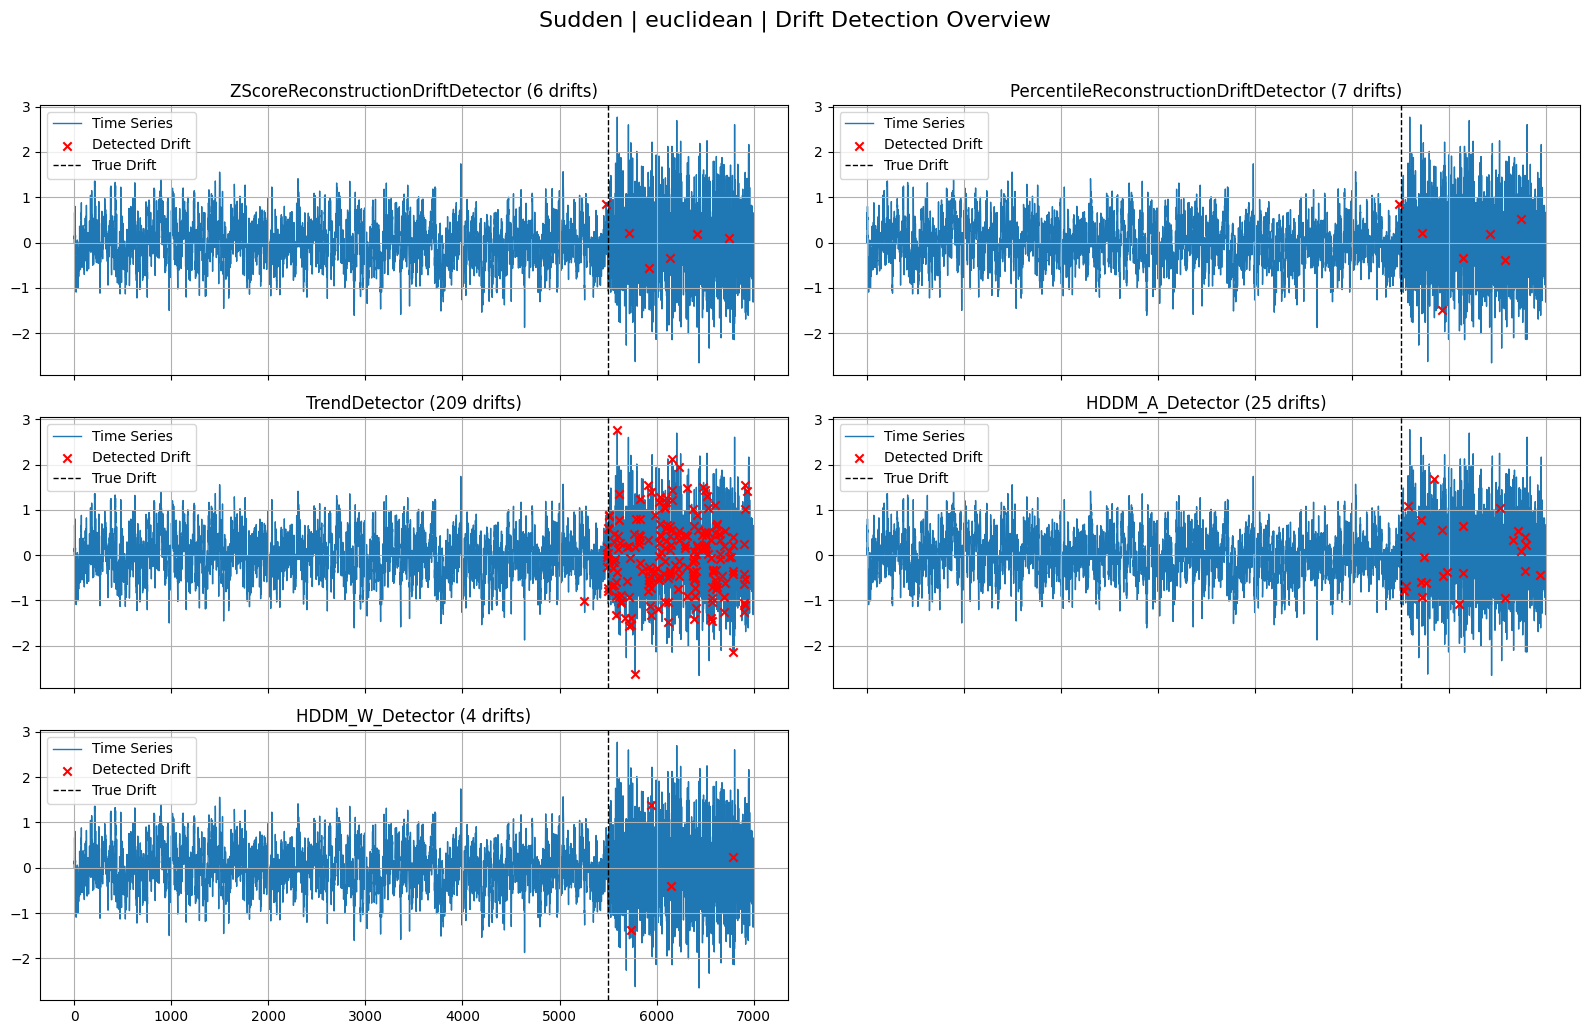


=== Dataset: Gradual ===
  > Metric: euclidean
    -> MSE: 3.5687


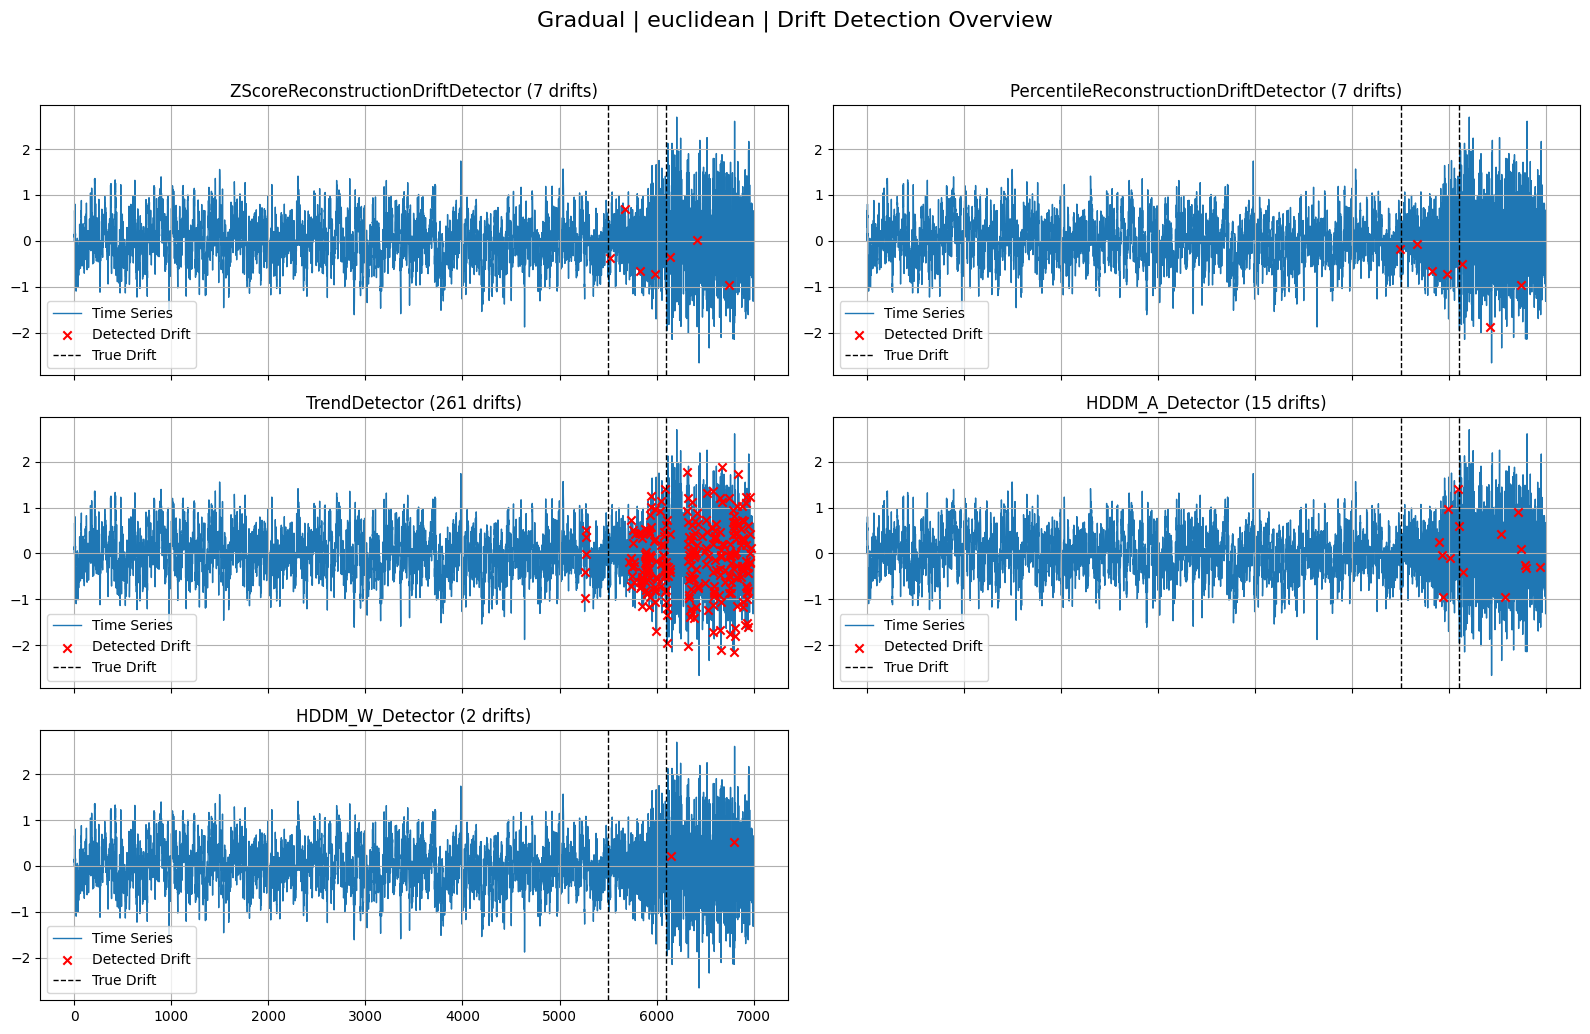

In [16]:
from collections import defaultdict

# Set the only metric to use
selected_metric = "euclidean"

# Ground truth drift points (by full-series index)
known_drifts = {
    "Sudden": [5500],
    "Gradual": [5500, 6100]
}

# Initialize detectors per dataset
detectors_per_ds = {}
for ds_name, *_ in ts_configs:
    detectors_per_ds[ds_name] = [
        ZScoreReconstructionDriftDetector(),
        PercentileReconstructionDriftDetector(),
        TrendDetector(),
        HDDM_A_Detector(),
        HDDM_W_Detector(),
    ]

print(f"Bottleneck size: {latent_dim}")

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    full_series = ts.data
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows = len(X_test)
    device = next(ae.parameters()).device

    test_start = len(X_train) + len(X_val)  # where test windows begin in full series

    lat_preds = []
    recon_errors = []

    # Reset detectors and drift log
    detectors = detectors_per_ds[ds_name]
    for det in detectors:
        det.reset()
    drift_hits = defaultdict(list)  # full_idx → list of detector names

    print(f"  > Metric: {selected_metric}")
    for idx, w in enumerate(X_test):
        # Prepare AE input
        x_tensor = (
            torch.from_numpy(w).float()
            .unsqueeze(0).unsqueeze(1)
            .to(device)
        )

        with torch.no_grad():
            recon = ae(x_tensor).squeeze().cpu().numpy()
            recon_error = np.mean((w - recon) ** 2)
            recon_errors.append(recon_error)

            q = ae.encoder(x_tensor).squeeze(0).cpu()

        # Latent distance-based model selection
        best_name, best_dist = None, float("inf")
        for name, model in forecasters.items():
            for entry in model.rocs["latent"]:
                d = compute_distance(q, entry, metric=selected_metric)
                if d < best_dist:
                    best_dist = d
                    best_name = name

        pred = forecasters[best_name].predict(w)
        lat_preds.append(pred)

        # Translate test window index to full series index
        full_idx = test_start + idx + window_size - 1

        for detector in detectors:
            triggered = detector.update(recon_error, idx)
            if triggered:
                drift_hits[full_idx].append(detector.__class__.__name__)

    # Print MSE
    mse_lat = mean_squared_error(y_test, lat_preds)
    print(f"    -> MSE: {mse_lat:.4f}")

    # --- Compact Grid Plot ---
    n = len(detectors)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows), sharex=True)
    axs = axs.flatten()

    for i, detector in enumerate(detectors):
        detector_name = detector.__class__.__name__
        drift_indices = [idx for idx, names in drift_hits.items() if detector_name in names]

        axs[i].plot(full_series, label="Time Series", linewidth=1, zorder=1)

        # Detected drift points
        if drift_indices:
            axs[i].scatter(
                drift_indices,
                [full_series[i] for i in drift_indices],
                color='red', marker='x', label='Detected Drift', zorder=2
            )

        # Ground-truth drift points
        if ds_name in known_drifts:
            for d in known_drifts[ds_name]:
                axs[i].axvline(d, color='black', linestyle='--', linewidth=1,
                               label='True Drift', zorder=3)

        # Unique legend
        handles, labels = axs[i].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axs[i].legend(by_label.values(), by_label.keys())

        axs[i].set_title(f"{detector_name} ({len(drift_indices)} drifts)")
        axs[i].grid(True)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    fig.suptitle(f"{ds_name} | {selected_metric} | Drift Detection Overview", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()